In [ ]:
# !pip install tensorflow-gpu==2.0.0
# !pip install keras==2.3.0

# load dependencies, set configurations

In [3]:
# %load_ext autoreload
# %autoreload 2
# %load_ext jupyternotify
# %autonotify -a 30

import math
import time
import sys
import os
import random
import pickle

import numpy as np

import keras
import keras.layers
import keras.applications
import keras.backend
import keras.preprocessing.image
import keras.utils
import tensorflow as tf

import cv2
import PIL
import PIL.Image
import matplotlib.pyplot as plt
import glob

import shutil


# configurations

## seeding
os.environ['PYTHONHASHSEED'] = '3'
np.random.seed(3)
random.seed(3)
#tf.set_random_seed(3)

# ## which gpu to use
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

## memory allocation
#config = tf.ConfigProto()
#config.gpu_options.allow_growth = True
# config.gpu_options.per_process_gpu_memory_fraction = 0.5
#session = tf.Session(config=config)
#keras.backend.set_session(session)

## data directory for CUB200 root
PATH_DATA_ROOT_CUB200 = "images"

## network configurations
### number of output classes, 200 for CUB200
NO_CLASS = 5



Using TensorFlow backend.


In [4]:
#!pip uninstall tensorflow

In [5]:
print(tf.__version__)
print(keras.__version__)

2.0.0
2.3.1


In [6]:
tf.test.is_gpu_available()

False

In [7]:
# ## which gpu to use
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# split CUB200 into train, valid 

In [8]:
import os
import random
from shutil import copyfile

def img_train_test_split(img_source_dir, train_size):
    """
    Randomly splits images over a train and validation folder, while preserving the folder structure
    
    Parameters
    ----------
    img_source_dir : string
        Path to the folder with the images to be split. Can be absolute or relative path   
        
    train_size : float
        Proportion of the original images that need to be copied in the subdirectory in the train folder
    """    
    if not (isinstance(img_source_dir, str)):
        raise AttributeError('img_source_dir must be a string')
        
    if not os.path.exists(img_source_dir):
        raise OSError('img_source_dir does not exist')
        
    if not (isinstance(train_size, float)):
        raise AttributeError('train_size must be a float')
        
    # Set up empty folder structure if not exists
    if not os.path.exists('data'):
        os.makedirs('data')
    else:
        if not os.path.exists('data/train'):
            os.makedirs('data/train')
        if not os.path.exists('data/valid'):
            os.makedirs('data/valid')
            
    # Get the subdirectories in the main image folder
    subdirs = [subdir for subdir in os.listdir(img_source_dir) if os.path.isdir(os.path.join(img_source_dir, subdir))]

    for subdir in subdirs:
        subdir_fullpath = os.path.join(img_source_dir, subdir)
        if len(os.listdir(subdir_fullpath)) == 0:
            print(subdir_fullpath + ' is empty')
            break

        train_subdir = os.path.join('data/train', subdir)
        validation_subdir = os.path.join('data/valid', subdir)

        # Create subdirectories in train and validation folders
        if not os.path.exists(train_subdir):
            os.makedirs(train_subdir)

        if not os.path.exists(validation_subdir):
            os.makedirs(validation_subdir)

        train_counter = 0
        validation_counter = 0

        # Randomly assign an image to train or validation folder
        for filename in os.listdir(subdir_fullpath):
            if filename.endswith(".jpg") or filename.endswith(".png"): 
                fileparts = filename.split('.')

                if random.uniform(0, 1) <= train_size:
                    copyfile(os.path.join(subdir_fullpath, filename), os.path.join(train_subdir, str(train_counter) + '.' + fileparts[1]))
                    train_counter += 1
                else:
                    copyfile(os.path.join(subdir_fullpath, filename), os.path.join(validation_subdir, str(validation_counter) + '.' + fileparts[1]))
                    validation_counter += 1
                    
        print('Copied ' + str(train_counter) + ' images to data/train/' + subdir)
        print('Copied ' + str(validation_counter) + ' images to data/valid/' + subdir)

In [9]:
data_path = 'images'
img_train_test_split(img_source_dir = data_path, train_size = 0.60)

Copied 37 images to data/train/001.Black_footed_Albatross
Copied 35 images to data/valid/001.Black_footed_Albatross
Copied 32 images to data/train/002.Laysan_Albatross
Copied 20 images to data/valid/002.Laysan_Albatross
Copied 35 images to data/train/003.Sooty_Albatross
Copied 17 images to data/valid/003.Sooty_Albatross
Copied 40 images to data/train/004.Groove_billed_Ani
Copied 30 images to data/valid/004.Groove_billed_Ani
Copied 32 images to data/train/005.Crested_Auklet
Copied 18 images to data/valid/005.Crested_Auklet


# preprocess images

In [10]:
def resize_image(x, size_target=None, flg_keep_aspect=False, rate_scale=1.0, flg_random_scale=False):

    # convert to numpy array
    if not isinstance(x, np.ndarray):
        img = np.asarray(x)
    else:
        img = x

    # calculate resize coefficients
    if len(img.shape) == 4:
        _o, size_height_img, size_width_img, _c , = img.shape
        img = img[0]
    elif len(img.shape) == 3:
        size_height_img, size_width_img, _c , = img.shape

    if len(size_target) == 1:
        size_heigth_target = size_target
        size_width_target = size_target
    if len(size_target) == 2:
        size_heigth_target = size_target[0]
        size_width_target = size_target[1]
    if size_target == None:
        size_heigth_target = size_height_img * rate_scale 
        size_width_target = size_width_img * rate_scale 

    coef_height = 1
    coef_width = 1
    if size_height_img < size_heigth_target :
        coef_height = size_heigth_target / size_height_img
    if size_width_img < size_width_target :
        coef_width = size_width_target / size_width_img

    # calculate coeffieient to match small size to target size
    ## scale coefficient if specified
    low_scale = rate_scale
    if flg_random_scale:
        low_scale = 1.0
    coef_max = max(coef_height, coef_width) * np.random.uniform(low=low_scale, high=rate_scale)

    # resize image
    size_height_resize = math.ceil(size_height_img*coef_max)
    size_width_resize = math.ceil(size_width_img*coef_max)

    # method_interpolation = cv2.INTER_LINEAR
    method_interpolation = cv2.INTER_CUBIC
    # method_interpolation = cv2.INTER_NEAREST

    if flg_keep_aspect:
        img_resized = cv2.resize(
                            img
                            , dsize=(size_width_resize, size_height_resize)
                            , interpolation=method_interpolation
                        )
    else:
        img_resized = cv2.resize(
                            img
                            , dsize=(
                                int(size_width_target*np.random.uniform(low=low_scale, high=rate_scale))
                                ,int(size_heigth_target*np.random.uniform(low=low_scale, high=rate_scale))
                            )
                            , interpolation=method_interpolation
                        )
    return img_resized

def resize_images(images, **kwargs):
    max_images = len(images)
    for i in range(max_images):
        images[i] = resize_image(images[i], **kwargs)
    return images

In [11]:
# crop image at the center
def center_crop_image(x, size_target=(448,448)):

    # convert to numpy array
    if not isinstance(x, np.ndarray):
        img = np.asarray(x)
    else:
        img = x

    # set size
    if len(size_target) == 1:
        size_heigth_target = size_target
        size_width_target = size_target
    if len(size_target) == 2:
        size_heigth_target = size_target[0]
        size_width_target = size_target[1]

    if len(img.shape) == 4:
        _o, size_height_img, size_width_img, _c , = img.shape
        img = img[0]
    elif len(img.shape) == 3:
        size_height_img, size_width_img, _c , = img.shape

    # crop image
    h_start = int((size_height_img - size_heigth_target) / 2)
    w_start = int((size_width_img - size_width_target) / 2)
    img_cropped = img[h_start:h_start+size_heigth_target, w_start:w_start+size_width_target, :]

    return img_cropped



# crop image of fixed-size from random point of top-left corner
def random_crop_image(x, size_target=(448,448)):

    # convert to numpy array
    if not isinstance(x, np.ndarray):
        img = np.asarray(x)
    else:
        img = x

    # set size
    if len(size_target) == 1:
        size_heigth_target = size_target
        size_width_target = size_target
    if len(size_target) == 2:
        size_heigth_target = size_target[0]
        size_width_target = size_target[1]

    if len(img.shape) == 4:
        _o, size_height_img, size_width_img, _c , = img.shape
        img = img[0]
    elif len(img.shape) == 3:
        size_height_img, size_width_img, _c , = img.shape

    # crop image
    margin_h = (size_height_img - size_heigth_target)
    margin_w = (size_width_img - size_width_target)
    h_start = 0 
    w_start = 0
    if margin_h != 0:
        h_start = np.random.randint(low=0, high=margin_h)
    if margin_w != 0:
        w_start = np.random.randint(low=0, high=margin_w) 
    img_cropped = img[h_start:h_start+size_heigth_target, w_start:w_start+size_width_target, :]

    return img_cropped



# flip image horizontally 
def horizontal_flip_image(x):
    
    if np.random.random() >= 0.5:
        return x[:,::-1,:]
    else:
        return x



# feature-wise normalization
def normalize_image(x, mean=(0., 0., 0.), std=(1.0, 1.0, 1.0)) :
    
    x = np.asarray(x, dtype=np.float32)

    if len(x.shape) == 4:
        for dim in range(3):
            x[:,:,:,dim] = ( x[:,:,:,dim] - mean[dim] ) / std[dim]
    if len(x.shape) == 3:
        for dim in range(3):
            x[:,:,dim] = ( x[:,:,dim] - mean[dim] ) / std[dim]

    return x


def check_images(images):
    fig=plt.figure(figsize=(8, 8))
    columns = 3
    rows = 3
    for i in range(1, columns*rows+1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(images[i-1].astype('uint8'))
    plt.show()

### original images

In [12]:
# check_images(trainval)

### resized images

In [13]:
# # resize images to generate cropped 448x448 images while keeping aspect ratio
# trainval_resized = resize_images(trainval, size_target=(448,448), flg_keep_aspect=True)
# check_images(trainval_resized)

### flipped images

In [14]:
# trainval_resized_flipped = trainval_resized.copy()
# for i in range(9):
#     trainval_resized_flipped[i] = horizontal_flip_image(trainval_resized_flipped[i])
# check_images(trainval_resized_flipped)

### center cropped images

In [15]:
# trainval_resized_cropped = trainval_resized.copy()
# for i in range(9):
#     trainval_resized_cropped[i] = center_crop_image(trainval_resized_cropped[i])
# check_images(trainval_resized_cropped)

### random cropped images

In [16]:
# trainval_resized_cropped = trainval_resized.copy()
# for i in range(9):
#     trainval_resized_cropped[i] = random_crop_image(trainval_resized_cropped[i])
# check_images(trainval_resized_cropped)

# load data

### bypass keras preprocessing for resizing images while keeping aspect ratio

In [17]:
import keras.backend as backend
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img

class DirectoryIterator(keras.preprocessing.image.DirectoryIterator):
    def _get_batches_of_transformed_samples(self, index_array):
        
        batch_x = np.zeros(
            (len(index_array),) + self.image_shape,
            dtype=backend.floatx())
        grayscale = self.color_mode == 'grayscale'
        
        # build batch of image data
        for i, j in enumerate(index_array):
            fname = self.filenames[j]
            img = load_img(os.path.join(self.directory, fname),
                           grayscale=grayscale,
                           target_size=None,
                           interpolation=self.interpolation)
            x = img_to_array(img, data_format=self.data_format)
            # Pillow images should be closed after `load_img`,
            # but not PIL images.
            if hasattr(img, 'close'):
                img.close()
            x = self.image_data_generator.standardize(x)
            batch_x[i] = x
            
        # optionally save augmented images to disk for debugging purposes
        if self.save_to_dir:
            for i, j in enumerate(index_array):
                img = array_to_img(batch_x[i], self.data_format, scale=True)
                fname = '{prefix}_{index}_{hash}.{format}'.format(
                    prefix=self.save_prefix,
                    index=j,
                    hash=np.random.randint(1e7),
                    format=self.save_format)
                img.save(os.path.join(self.save_to_dir, fname))
                
        # build batch of labels
        if self.class_mode == 'input':
            batch_y = batch_x.copy()
        elif self.class_mode == 'sparse':
            batch_y = self.classes[index_array]
        elif self.class_mode == 'binary':
            batch_y = self.classes[index_array].astype(backend.floatx())
        elif self.class_mode == 'categorical':
            batch_y = np.zeros(
                (len(batch_x), self.num_classes),
                dtype=backend.floatx())
            for i, label in enumerate(self.classes[index_array]):
                batch_y[i, label] = 1.
        else:
            return batch_x
        
        return batch_x, batch_y


class ImageDataGenerator(keras.preprocessing.image.ImageDataGenerator):
    def flow_from_directory(self, directory,
                            target_size=(256, 256), color_mode='rgb',
                            classes=None, class_mode='categorical',
                            batch_size=16, shuffle=True, seed=None,
                            save_to_dir=None,
                            save_prefix='',
                            save_format='png',
                            follow_links=False,
                            subset=None,
                            interpolation='nearest'):

        return DirectoryIterator(
            directory, self,
            target_size=target_size, color_mode=color_mode,
            classes=classes, class_mode=class_mode,
            data_format=self.data_format,
            batch_size=batch_size, shuffle=shuffle, seed=seed,
            save_to_dir=save_to_dir,
            save_prefix=save_prefix,
            save_format=save_format,
            follow_links=follow_links,
            subset=subset,
            interpolation=interpolation)

In [18]:
def load_data(
    path_data_train=None
    ,path_data_valid=None
    ,size_width=448
    ,size_heigth=448
    ,size_mini_batch=16
    
    ,flg_debug=False
    ,**kwargs
):
                    
    # set preprocessing functions       
    func_train = lambda x :normalize_image(
                                random_crop_image(
                                    horizontal_flip_image(
                                        resize_image(x, size_target=(size_heigth,size_width), flg_keep_aspect=True)
                                    )
                                )
                                ,mean=[123.82988033, 127.3509729, 110.25606303]
                            )
    func_valid = lambda x :normalize_image(
                                center_crop_image(
                                    resize_image(x, size_target=(size_heigth,size_width), flg_keep_aspect=True)
                                )
                                ,mean=[123.82988033, 127.3509729, 110.25606303]
                            )
    
    # set image_data_generator 
    gen_train = ImageDataGenerator(   
                    preprocessing_function=func_train
                )

    gen_valid = ImageDataGenerator(
                    preprocessing_function=func_valid
                )

    gen_dir_train = gen_train.flow_from_directory(
                            path_data_train
                            ,target_size=(size_heigth, size_width)
                            ,batch_size=size_mini_batch
                        )

    gen_dir_valid = gen_valid.flow_from_directory(
                            path_data_valid
                            ,target_size=(size_heigth, size_width)
                            ,batch_size=size_mini_batch
                            ,shuffle=False
                    )

    return gen_dir_train, gen_dir_valid

In [19]:
gen_dir_train, gen_dir_valid = load_data(
                                    path_data_train="data/train"
                                    ,path_data_valid="data/valid"
                                    ,size_mini_batch=9
                                )

Found 87 images belonging to 5 classes.
Found 61 images belonging to 5 classes.


### check preprocessed training images

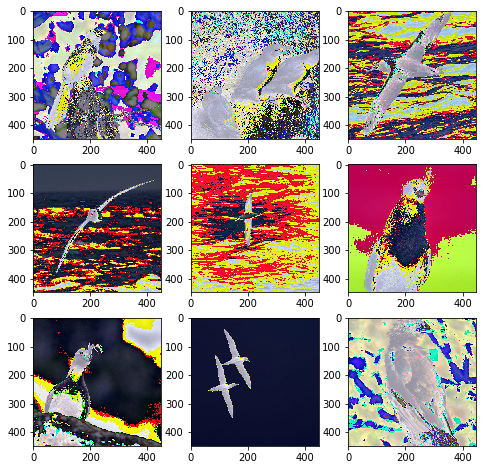

In [20]:
x_train, y_train = gen_dir_train.next()
check_images(x_train)

# build model

In [21]:
from keras.initializers import glorot_normal

def outer_product(x):
    """
    calculate outer-products of 2 tensors

        args 
            x
                list of 2 tensors
                , assuming each of which has shape = (size_minibatch, total_pixels, size_filter)
    """
    return keras.backend.batch_dot(
                x[0]
                , x[1]
                , axes=[1,1]
            ) / x[0].get_shape().as_list()[1] 

def signed_sqrt(x):
    """
    calculate element-wise signed square root

        args
            x
                a tensor
    """
    return keras.backend.sign(x) * keras.backend.sqrt(keras.backend.abs(x) + 1e-9)

def L2_norm(x, axis=-1):
    """
    calculate L2-norm

        args 
            x
                a tensor
    """
    return keras.backend.l2_normalize(x, axis=axis)


def build_model(
    size_heigth=448
    ,size_width=448
    ,no_class=200
    ,no_last_layer_backbone=17
    
    ,name_optimizer="sgd"
    ,rate_learning=1.0
    ,rate_decay_learning=0.0
    ,rate_decay_weight=0.0
    
    ,name_initializer="glorot_normal"
    ,name_activation_logits="softmax"
    ,name_loss="categorical_crossentropy"

    ,flg_debug=False
    ,**kwargs
):
    
    keras.backend.clear_session()
    
    print("-------------------------------")
    print("parameters:")
    for key, val in locals().items():
        if not val == None and not key == "kwargs":
            print("\t", key, "=",  val)
    print("-------------------------------")
    
    ### 
    ### load pre-trained model
    ###
    tensor_input = keras.layers.Input(shape=[size_heigth,size_width,3])
    model_detector = keras.applications.vgg16.VGG16(
                            input_tensor=tensor_input
                            , include_top=False
                            , weights='imagenet'
                        )
    

    ### 
    ### bi-linear pooling
    ###

    # extract features from detector
    x_detector = model_detector.layers[no_last_layer_backbone].output
    shape_detector = model_detector.layers[no_last_layer_backbone].output_shape
    if flg_debug:
        print("shape_detector : {}".format(shape_detector))

    # extract features from extractor , same with detector for symmetry DxD model
    shape_extractor = shape_detector
    x_extractor = x_detector
    if flg_debug:
        print("shape_extractor : {}".format(shape_extractor))
        
    
    # rehape to (minibatch_size, total_pixels, filter_size)
    x_detector = keras.layers.Reshape(
            [
                shape_detector[1] * shape_detector[2] , shape_detector[-1]
            ]
        )(x_detector)
    if flg_debug:
        print("x_detector shape after rehsape ops : {}".format(x_detector.shape))
        
    x_extractor = keras.layers.Reshape(
            [
                shape_extractor[1] * shape_extractor[2] , shape_extractor[-1]
            ]
        )(x_extractor)
    if flg_debug:
        print("x_extractor shape after rehsape ops : {}".format(x_extractor.shape))
        
        
    # outer products of features, output shape=(minibatch_size, filter_size_detector*filter_size_extractor)
    x = keras.layers.Lambda(outer_product)(
        [x_detector, x_extractor]
    )
    if flg_debug:
        print("x shape after outer products ops : {}".format(x.shape))
        
        
    # rehape to (minibatch_size, filter_size_detector*filter_size_extractor)
    x = keras.layers.Reshape([shape_detector[-1]*shape_extractor[-1]])(x)
    if flg_debug:
        print("x shape after rehsape ops : {}".format(x.shape))
        
        
    # signed square-root 
    x = keras.layers.Lambda(signed_sqrt)(x)
    if flg_debug:
        print("x shape after signed-square-root ops : {}".format(x.shape))
        
    # L2 normalization
    x = keras.layers.Lambda(L2_norm)(x)
    if flg_debug:
        print("x shape after L2-Normalization ops : {}".format(x.shape))



    ### 
    ### attach FC-Layer
    ###

    if name_initializer != None:
            name_initializer = eval(name_initializer+"()")
            
    x = keras.layers.Dense(
            units=no_class
            ,kernel_regularizer=keras.regularizers.l2(rate_decay_weight)
            ,kernel_initializer=name_initializer
        )(x)
    if flg_debug:
        print("x shape after Dense ops : {}".format(x.shape))
    tensor_prediction = keras.layers.Activation(name_activation_logits)(x)
    if flg_debug:
        print("prediction shape : {}".format(tensor_prediction.shape))

        

    ### 
    ### compile model
    ###
    model_bilinear = keras.models.Model(
                        inputs=[tensor_input]
                        , outputs=[tensor_prediction]
                    )
    
    
    # fix pre-trained weights
    for layer in model_detector.layers:
        layer.trainable = False
        
        
    # define optimizers
    opt_adam = keras.optimizers.adam(
                    lr=rate_learning
                    , decay=rate_decay_learning
                )
    opt_rms = keras.optimizers.RMSprop(
                    lr=rate_learning
                    , decay=rate_decay_learning
                )
    opt_sgd = keras.optimizers.SGD(
                    lr=rate_learning
                    , decay=rate_decay_learning
                    , momentum=0.9
                    , nesterov=False
                )
    optimizers ={
        "adam":opt_adam
        ,"rmsprop":opt_rms
        ,"sgd":opt_sgd
    }
    
    model_bilinear.compile(
        loss=name_loss
        , optimizer=optimizers[name_optimizer]
        , metrics=["categorical_accuracy"]
    )
    
    
    
    if flg_debug:
        model_bilinear.summary()
    
    return model_bilinear

In [22]:
model = build_model(
            # number of output classes, 200 for CUB200
            no_class = NO_CLASS

            # pretrained model specification, using VGG16
            # "block5_conv3 "
            ,no_last_layer_backbone = 17
    
            # training parametes
            ,rate_learning=1.0
            ,rate_decay_weight=1e-8
    
            ,flg_debug=True
        )

-------------------------------
parameters:
	 flg_debug = True
	 name_loss = categorical_crossentropy
	 name_activation_logits = softmax
	 name_initializer = glorot_normal
	 rate_decay_weight = 1e-08
	 rate_decay_learning = 0.0
	 rate_learning = 1.0
	 name_optimizer = sgd
	 no_last_layer_backbone = 17
	 no_class = 5
	 size_width = 448
	 size_heigth = 448
-------------------------------
shape_detector : (None, 28, 28, 512)
shape_extractor : (None, 28, 28, 512)
x_detector shape after rehsape ops : (None, 784, 512)
x_extractor shape after rehsape ops : (None, 784, 512)
x shape after outer products ops : (None, 512, 512)
x shape after rehsape ops : (None, 262144)
x shape after signed-square-root ops : (None, 262144)
x shape after L2-Normalization ops : (None, 262144)
x shape after Dense ops : (None, 5)
prediction shape : (None, 5)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape 

# train model

In [26]:
from tensorflow.keras.models import save_model, Model, load_model

In [71]:
def train_model(
        model=None
        ,name_model="BCNN_keras"
        ,gen_dir_train=None
        ,gen_dir_valid=None
        ,max_epoch=50
    ):
    
    path_model = "./model/{}/".format(name_model)
    if not os.path.exists(path_model):
        os.mkdir(path_model)
        
    now = time.strftime("%Y%m%d%H%M%S", time.localtime())
        
    # callback setting
    callback_logger = keras.callbacks.CSVLogger(
                            path_model +  "log_training_{}.csv".format(now)
                            , separator=','
                            , append=False
                        )
    callack_saver = keras.callbacks.ModelCheckpoint(
                        path_model
                            + "E[{epoch:02d}]"
                            + "_LOS[{val_loss:.3f}]"
                            + "_ACC[{val_categorical_accuracy:.3f}]"
                            + ".hdf5" 
                        , monitor='val_loss'
                        , verbose=0
                        , mode='auto'
                        , period=10
                        , save_best_only=True
                    )
    callback_reducer = keras.callbacks.ReduceLROnPlateau(
                                monitor='val_loss'
                                , factor=0.5
                                , patience=5                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
                                , min_lr=1e-6
                                , min_delta=1e-3
                            )
    callback_stopper = keras.callbacks.EarlyStopping(
                            monitor='val_loss'
                            , min_delta=1e-3
                            , patience=10
                            , verbose=0
                            , mode='auto'
                        )
    list_callback = [
        callback_logger
        ,callack_saver
        ,callback_reducer
        ,callback_stopper
    ]
            
    hist = model.fit_generator(
                gen_dir_train
                , epochs=max_epoch
                , validation_data=gen_dir_valid
                ,callbacks=list_callback
                ,workers=3
                ,verbose=1
            )
        
    model.save_weights(
        path_model
            + "E[{}]".format(len(hist.history['val_loss']))
            + "_LOS[{:.3f}]".format(hist.history['val_loss'][-1])
            + "_ACC[{:.3f}]".format(hist.history['val_categorical_accuracy'][-1])
            + ".h5" 
    )
    #model.save()
    model.save('newmodel.h5')
#     m = Model()
#     save_model(m, './model/BCNN/')
#     #save_model(model=, filepath='./model/BCNN_keras/')
    
    return hist                                              

In [72]:
hist =train_model(
            model=model
            ,gen_dir_train=gen_dir_train
            ,gen_dir_valid=gen_dir_valid
            ,max_epoch=1

        )

Epoch 1/1
 9/10 [==========================>...] - ETA: 8s - loss: 0.0470 - categorical_accuracy: 1.0000 

KeyboardInterrupt: 

# finetune only FC-layer

In [ ]:
hist =train_model(
            model=model
            ,gen_dir_train=gen_dir_train
            ,gen_dir_valid=gen_dir_valid
            ,max_epoch=1

        )

# finetune ALL-layer

In [ ]:
# now all layers are trainable
for layer in model.layers:
    layer.trainable = True

# change LR
opt_sgd = keras.optimizers.SGD(
                lr=1e-3
                , decay=1e-9
                , momentum=0.9
                , nesterov=False
            )
model.compile(
    loss="categorical_crossentropy"
    , optimizer=opt_sgd
    , metrics=["categorical_accuracy"]
)

In [ ]:
hist =train_model(
            model=model
            ,gen_dir_train=gen_dir_train
            ,gen_dir_valid=gen_dir_valid
            ,max_epoch=1

        )

hist =train_model(
            model=model
            ,gen_dir_train=gen_dir_train
            ,gen_dir_valid=gen_dir_valid
            ,max_epoch=33

        )

# Prediction

In [29]:
import keras
from tensorflow.keras.models import load_model, Model

In [33]:
loaded_model = model.load_weights("./model/BCNN_keras/E[1]_LOS[0.378]_ACC[0.918].h5")

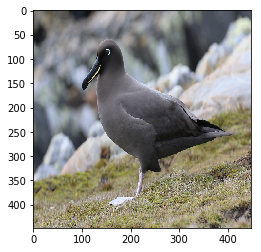

In [44]:
import pandas as pd

from keras.preprocessing import image 
import matplotlib.pyplot as plt

image_path = "test_img/sooty_albatross.jpg"

img = image.load_img(image_path, target_size= (448, 448)) 
plt.imshow(img)


In [47]:
dataset_labels = sorted(gen_dir_train.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key for key, value in dataset_labels ])

In [48]:
print(dataset_labels)

['001.Black_footed_Albatross' '002.Laysan_Albatross' '003.Sooty_Albatross'
 '004.Groove_billed_Ani' '005.Crested_Auklet']


In [51]:
img = image.img_to_array(img)

In [52]:
img = np.expand_dims(img, axis=0)

In [55]:
predicted_val = model.predict(img)
predicted_val

array([[0.0835064 , 0.38465953, 0.44847244, 0.00500674, 0.07835492]],
      dtype=float32)

In [58]:
predicted_val_df = pd.DataFrame(predicted_val)

In [59]:
predicted_val_df.columns = dataset_labels

In [60]:
predicted_val_df

,001.Black_footed_Albatross,002.Laysan_Albatross,003.Sooty_Albatross,004.Groove_billed_Ani,005.Crested_Auklet
0,0.083506,0.38466,0.448472,0.005007,0.078355


In [62]:
predicted_val.argmax()

2

In [70]:
dataset_labels[predicted_val.argmax()]

'003.Sooty_Albatross'

# Thus our prediction is correct

In [ ]:
#step 1 : install dependencies and setup env

!echo "deb [arch=amd64] http://"